In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests_hw4 import test_prediction, test_generation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/junhyunb/anaconda3/envs/idl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [3]:
# data loader

class DataLoaderForLanguageModeling(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.sequence_length = 100

    def __iter__(self):
        """
            You may implement some of the techniques in https://arxiv.org/pdf/1708.02182.pdf
            example: Variable length backpropagation sequences (Section 4.1)
        """
        # 1. Randomly shuffle all the articles from the WikiText-2 dataset.
        # 2. Concatenate all text in one long string.
        # 3. Group the sequences into batches.
        # 4. Run a loop that returns a tuple of (input, label) on every iteration with yield.

        if self.shuffle:
            shuffled_dataset = np.random.permutation(self.dataset)
        else:
            shuffled_dataset = self.dataset
            
        concatenated_dataset = np.concatenate(shuffled_dataset)
        num_batches = len(concatenated_dataset) // (self.batch_size * self.sequence_length)
        
        count = 0

        for i in range(num_batches):
            inputs = []
            targets = []
            for j in range(self.batch_size):
                start_idx = count * self.sequence_length
                end_idx = start_idx + self.sequence_length + 1
                inputs.append(concatenated_dataset[start_idx:end_idx-1])
                targets.append(concatenated_dataset[start_idx+1:end_idx])

                count += 1
            
            yield np.array(inputs), np.array(targets)

    def dynamic_seq_len(self, seq_len):
        seq_len = seq_len if np.random.random() < 0.95 else seq_len / 2
        seq_len = 0

        return 0

In [4]:
# model

class Model(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size:int, embedding_dim:int, hidden_size:int):
        super(Model, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_size, num_layers=2, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, x):
        embedded_input = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded_input)
        output = self.linear(output)
        
        return output

In [5]:
# model trainer

class Trainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model.to(device)
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        # feel free to define a learning rate scheduler as well if you want

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
            
            :return 
                    (float) loss value
        """
        self.model.train()
        inputs = torch.LongTensor(inputs).to(device)
        targets = torch.LongTensor(targets).to(device)
        self.optimizer.zero_grad()
        output = self.model(inputs)
        loss = self.criterion(
            output.transpose(1,2), targets
            )
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.predict(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generate(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generate(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.predict(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        self.epochs += 1

        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [6]:

class TestLanguageModel:
    def predict(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        model.eval()
        with torch.no_grad():
            inp = torch.LongTensor(inp).to(device)
            output = model(inp) # (bsz, seq_len, vocab_size)
            output = output[:, -1, :]
        
        return output.cpu().detach().numpy()
        
    def generate(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """
        inp = torch.LongTensor(inp).to(device)
        inp_length = inp.size(1)
        model.eval()
        
        with torch.no_grad():
            output = model(inp)
            output = output[:, -1, :]
            output_text = torch.argmax(output, dim=1)
            
            for i in range(forward):
                inp = torch.cat((inp, output_text.unsqueeze(1)), dim=1)
                output = model(inp)
                output = output[:, -1, :]
                output_text = torch.argmax(output, dim=1)

        return inp[:, inp_length:].cpu().detach().numpy()

In [7]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 20
BATCH_SIZE = 200
EMB_DIM = 512
HIDDEN_SIZE = 512

In [8]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1670442001


In [9]:
model = Model(len(vocab), embedding_dim=EMB_DIM, hidden_size=HIDDEN_SIZE)

loader = DataLoaderForLanguageModeling(
    dataset=dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
trainer = Trainer(
    model=model, 
    loader=loader, 
    max_epochs=NUM_EPOCHS, 
    run_id=run_id
)

In [10]:
best_nll = 1e30 

for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        
        trainer.save()

[TRAIN]  Epoch [1/20]   Loss: 7.5761
[VAL]  Epoch [1/20]   Loss: 6.7027
Saving model, predictions and generated output for epoch 0 with NLL: 6.7026663
[TRAIN]  Epoch [2/20]   Loss: 7.2681
[VAL]  Epoch [2/20]   Loss: 6.6979
Saving model, predictions and generated output for epoch 1 with NLL: 6.6978927
[TRAIN]  Epoch [3/20]   Loss: 7.1773
[VAL]  Epoch [3/20]   Loss: 6.4793
Saving model, predictions and generated output for epoch 2 with NLL: 6.4792824
[TRAIN]  Epoch [4/20]   Loss: 7.0262
[VAL]  Epoch [4/20]   Loss: 6.2634
Saving model, predictions and generated output for epoch 3 with NLL: 6.2634416
[TRAIN]  Epoch [5/20]   Loss: 6.7755
[VAL]  Epoch [5/20]   Loss: 6.1080
Saving model, predictions and generated output for epoch 4 with NLL: 6.1080494
[TRAIN]  Epoch [6/20]   Loss: 6.5563
[VAL]  Epoch [6/20]   Loss: 5.8577
Saving model, predictions and generated output for epoch 5 with NLL: 5.857664
[TRAIN]  Epoch [7/20]   Loss: 6.3686
[VAL]  Epoch [7/20]   Loss: 5.7622
Saving model, predictio

In [11]:
# nll = trainer.test()

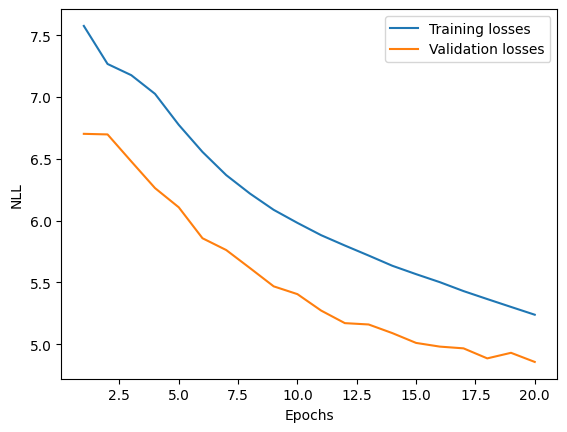

In [12]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [13]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | also used to the <unk> of the <unk> ,
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> = = = = <eol>
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | @-@ year @-@ year @-@ yard . <eol> =
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and the <unk> of the <unk> . <eol> =
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | @-@ <unk> . <eol> = = = = <unk>
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | , and the <unk> of the <unk> <unk> .
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest in South Korea , notabl